Dieses Model wird mit TPU trainiert, wenn über GPU trainiert werden soll CUDA und cuDNN Version anpassen

In [1]:
!pip3 install tensorflow==2.6.*
!pip3 install keras==2.6.*
!pip3 install imgaug

     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 462 kB 67.8 MB/s 
     |████████████████████████████████| 1.3 MB 66.6 MB/s 
     |████████████████████████████████| 5.6 MB 31.5 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=74c64cc4c60f05f3fb8fcf1df3217842e0c0b61d7f372cae0efdb03ed2cd775c
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68715 sha256=2de0360bb9173d50cca2adb738af8ea30de85c7d1034b7b079fceb6f3631908e
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [3]:
print('tensorflow @ version ', tf.__version__)
print('keras @ version ', keras.__version__)

tensorflow @ version  2.6.2
keras @ version  2.6.0


In [4]:
os.listdir("/content/drive/MyDrive/Projekte/Self-Driving-Car/Software/model_training/Lane-Detection/data/")

['raspicar', 'simulator']

raspicar bidler resizen auf gleiche größe von simulator bildern und abfrage einbauen

In [5]:
!mkdir data
!mkdir IMG
!cp -r /content/drive/MyDrive/Projekte/Self-Driving-Car/Software/model_training/Lane-Detection/data/* /content/data
!cp -r /content/data/raspicar/IMG/* IMG
!cp -r /content/data/simulator/IMG/* IMG

In [6]:
dir = "data"
IMG = "IMG"
raspicar = "raspicar"
simulator = "simulator"

Simulator Data

In [7]:
datadir_sim = os.path.join(dir, simulator)
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data_sim = pd.read_csv(os.path.join(datadir_sim, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data_sim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438
...,...,...,...,...,...,...,...
4048,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_16_31_474.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_16_31_474.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_16_31_474.jpg,0.0,0.0,0.0,26.017680
4049,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_16_31_544.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_16_31_544.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_16_31_544.jpg,0.0,0.0,0.0,25.808640
4050,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_16_31_617.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_16_31_617.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_16_31_617.jpg,0.0,0.0,0.0,25.652960
4051,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_16_31_685.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_16_31_685.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_16_31_685.jpg,0.0,0.0,0.0,25.446850


RaspiCar Data

In [19]:
datadir_car = datadir = os.path.join(dir, raspicar)
columns = ['center', 'steering', 'throttle', 'reverse', 'speed']
data_car = pd.read_csv(os.path.join(datadir_car, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data_car['steering'] = data_car['steering'].round(1)
#if abfrage ob reihe NaN
data_car.drop(data_car.tail(1).index, inplace=True)
data_car

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,steering,throttle,reverse,speed
0,/home/pi/training_data/IMG/center_2021_12_14_13_59_39_0.jpg,0.0,372.0,0.0,0.0
1,/home/pi/training_data/IMG/center_2021_12_14_13_59_39_1.jpg,0.0,372.0,0.0,0.0
2,/home/pi/training_data/IMG/center_2021_12_14_13_59_39_2.jpg,0.0,372.0,0.0,0.0
3,/home/pi/training_data/IMG/center_2021_12_14_13_59_39_3.jpg,0.0,372.0,0.0,0.0
4,/home/pi/training_data/IMG/center_2021_12_14_13_59_39_4.jpg,0.0,372.0,0.0,0.0
...,...,...,...,...,...
2876,/home/pi/training_data/IMG/center_2021_12_14_14_04_07_706.jpg,0.0,375.0,0.0,0.0
2877,/home/pi/training_data/IMG/center_2021_12_14_14_04_07_707.jpg,0.0,375.0,0.0,0.0
2878,/home/pi/training_data/IMG/center_2021_12_14_14_04_07_708.jpg,0.0,375.0,0.0,0.0
2879,/home/pi/training_data/IMG/center_2021_12_14_14_04_07_709.jpg,0.0,375.0,0.0,0.0


In [20]:
data = pd.concat([data_sim, data_car], ignore_index=True)
data

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438
...,...,...,...,...,...,...,...
6929,/home/pi/training_data/IMG/center_2021_12_14_14_04_07_706.jpg,NaN,NaN,0.0,375.0,0.0,0.000000
6930,/home/pi/training_data/IMG/center_2021_12_14_14_04_07_707.jpg,NaN,NaN,0.0,375.0,0.0,0.000000
6931,/home/pi/training_data/IMG/center_2021_12_14_14_04_07_708.jpg,NaN,NaN,0.0,375.0,0.0,0.000000
6932,/home/pi/training_data/IMG/center_2021_12_14_14_04_07_709.jpg,NaN,NaN,0.0,375.0,0.0,0.000000


In [10]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [21]:
data = data.drop(columns=["left", "right"])
data['center'] = data['center'].apply(path_leaf)
#data['left'] = data['left'].apply(path_leaf)
#data['right'] = data['right'].apply(path_leaf)
data

,center,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438
...,...,...,...,...,...
6929,center_2021_12_14_14_04_07_706.jpg,0.0,375.0,0.0,0.000000
6930,center_2021_12_14_14_04_07_707.jpg,0.0,375.0,0.0,0.000000
6931,center_2021_12_14_14_04_07_708.jpg,0.0,375.0,0.0,0.000000
6932,center_2021_12_14_14_04_07_709.jpg,0.0,375.0,0.0,0.000000


total data: 6934
removed: 3660
remaining: 3274
center      center_2018_07_16_17_11_44_485.jpg
steering   -0.25                              
throttle    0.863326                          
reverse     0                                 
speed       2.17305                           
Name: 13, dtype: object


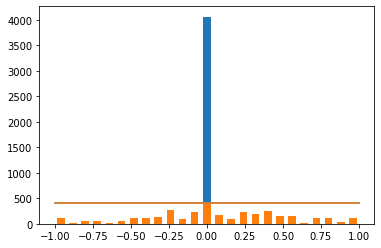

In [22]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'].iloc[i] >= bins[j] and data['steering'].iloc[i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print(data.iloc[1])

In [23]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center = indexed_data[0]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[1]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

Training Samples: 2619
Valid Samples: 655


Text(0.5, 1.0, 'Validation set')

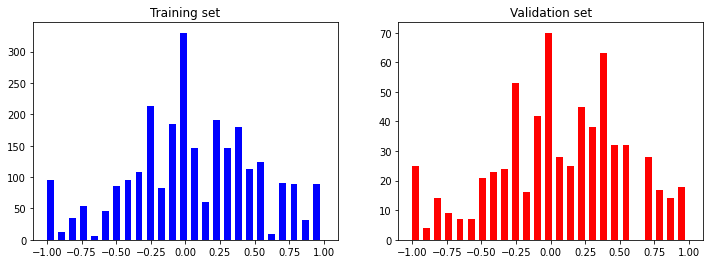

In [24]:
image_paths, steerings = load_img_steering(IMG, data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [25]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

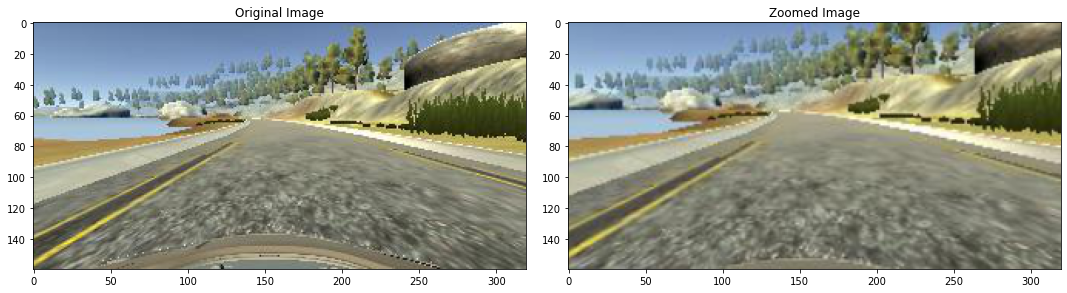

In [26]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [27]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

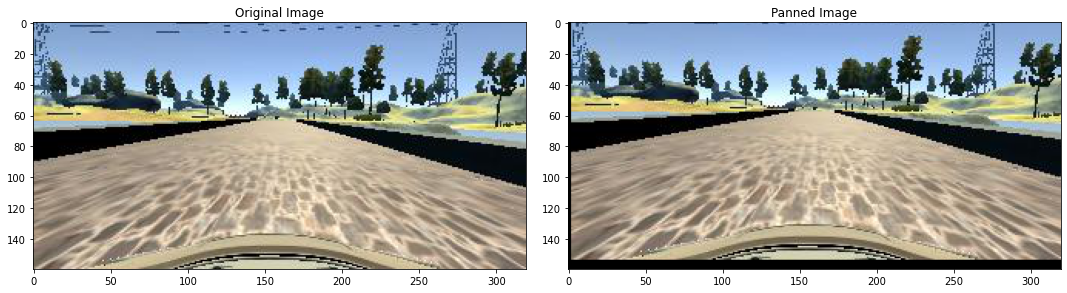

In [28]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [29]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

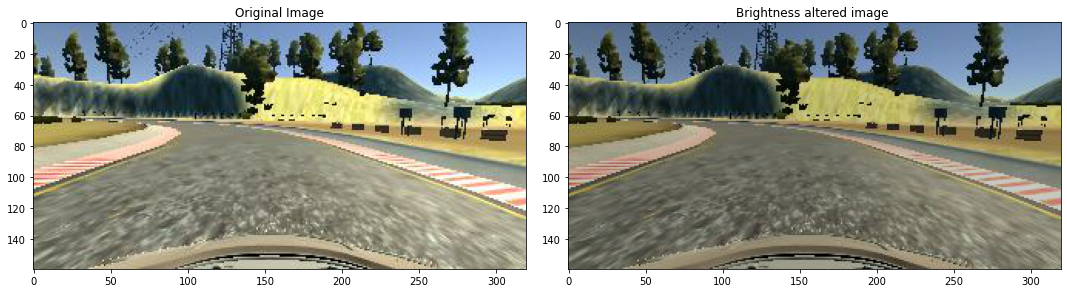

In [30]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [31]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.0')

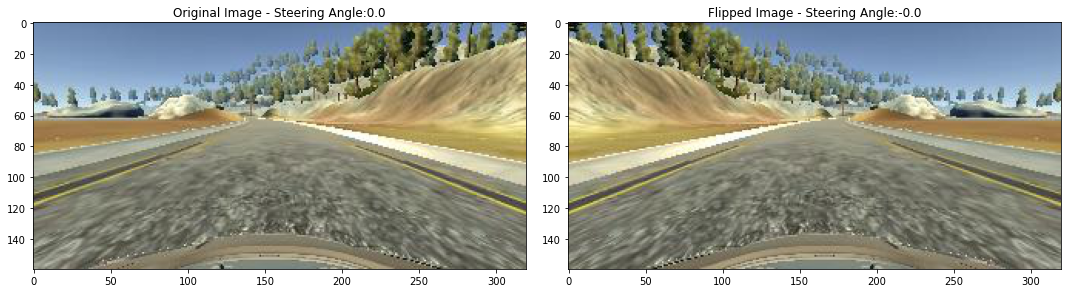

In [32]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [33]:
#Fehler im img preprocessing, raspicar bilder sind größer

def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [34]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [35]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")


image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

Output hidden; open in https://colab.research.google.com to view.

In [36]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [37]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))

  model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

Text(0.5, 1.0, 'Validation Image')

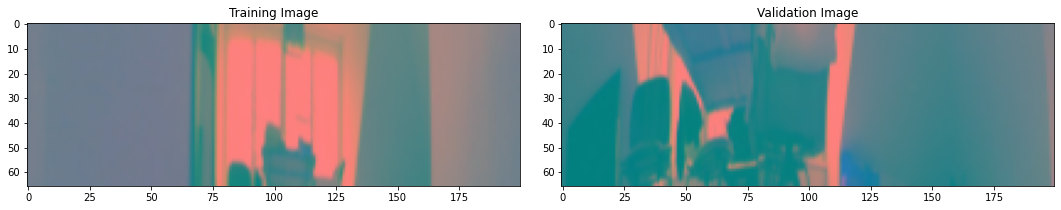

In [38]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [40]:
model = nvidia_model()
print(model.summary())
history = model.fit(batch_generator(X_train, y_train, 100, 1), steps_per_epoch=300, epochs=10, validation_data=batch_generator(X_valid, y_valid, 100, 0), validation_steps=200, verbose=1, shuffle = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 6, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')